In [11]:
import torch
import matplotlib.pyplot as plt
import warnings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Exact diagonalization

The potential is $V(x) = V_0 \sin^2(k_1 x)$, with period $k_1 x= 2\pi n\to x = \frac{2\pi}{k_1}n$. This means the hamiltonian is:

$$H = -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}+V_0 \sin^2(k_1 x)$$

To construct the exact diagonalization, we use the usual finite differences for the kinetic term:

$$K\psi = -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}\psi\approx -\frac{\hbar^2}{2m}\frac{\psi_{i-1}-2\psi_i+\psi_{i+1}}{h^2}$$

Where we discretized $\psi(x)\to \psi(x_i)\equiv\psi_i$ in an equispaced grid with spacing $h\equiv x_{i}-x_{i-1}$. Expressing psi as a vector such as:

$$\psi = \begin{pmatrix}\psi_1\\\psi_2\\\vdots\\\psi_N\end{pmatrix}$$

We see that the kinetic operator can be expressed as a tridiagonal matrix:

$$K = -\frac{\hbar^2}{2mh^2}(-2\delta_{i,j}+\delta_{i, j+1}+\delta_{i, j-1})=-\frac{\hbar^2}{2mh^2}\begin{pmatrix}-2&1&0&\dots&0\\1&-2&1&\dots&0\\0&1&-2&\dots&0\\\vdots&\vdots&\vdots&\ddots&1\\0&0&0&\dots&-2\end{pmatrix}$$

## Boundary conditions

If PBC, then at positions [0,-1] and [-1,0] there has to be a 1.

In [13]:
# PARAMETERS
HBAR = 1.0
MASS = 1.0
V0 = 1.0
K1 = 1.0
PBC = True

N_POINTS = 1_000
N_PERIODS_FROM_CENTRE_TO_RIGHT = 3 # number of periods from the center to the right edge
# A = 2*N_PERIODS_FROM_CENTRE_TO_RIGHT-1 # number of periods in the box centered at zero
A = N_PERIODS_FROM_CENTRE_TO_RIGHT
L_BOX = 2*torch.pi/K1 * A
GRID_SPACING = L_BOX / N_POINTS
# if GRID_SPACING < torch.pi/(K1):
#     warnings.warn("Aliasing may occur: N_POINTS is too small for the given K1.")
torch.set_default_dtype(torch.float64)

# Create a grid of points
x = torch.linspace(-L_BOX/2,L_BOX/2, N_POINTS).to(device)

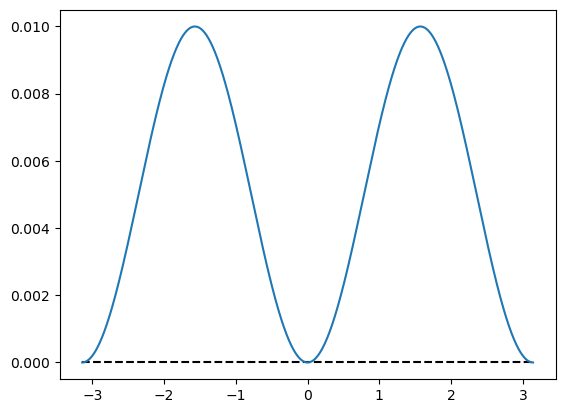

In [30]:
def V(x,V0):
    """Potential function."""
    return V0 * torch.sin(K1 * x).pow(2)

plt.hlines(0, -L_BOX/2, L_BOX/2, colors='black', linestyles='dashed')
plt.plot(x.cpu().numpy(), V(x,V0).cpu().numpy(), label='Potential V(x)')

In [31]:
def hamiltonian_matrix(N_POINTS, GRID_SPACING, PBC):
    kin_coeff = -HBAR**2 / (2 * MASS * GRID_SPACING**2)
    kin_main_diag = -2*torch.ones(N_POINTS, device=device)  # Main diagonal for kinetic energy
    kin_off_diags = 1*torch.ones(N_POINTS-1, device=device)  # Off-diagonal elements for kinetic energy
    # kin_matrix = torch.zeros((N_POINTS, N_POINTS))
    kin_matrix = torch.diag(kin_main_diag).to(device)
    kin_matrix += torch.diag(kin_off_diags, diagonal=1)
    kin_matrix += torch.diag(kin_off_diags, diagonal=-1)
    if PBC:
        kin_matrix[0, -1] = 1
        kin_matrix[-1, 0] = 1
    pot_matrix = torch.zeros((N_POINTS, N_POINTS), device=device)
    for i in range(N_POINTS):
        pot_matrix[i, i] = V(x[i],V0)
        # TO TRY HARMONIC POTENTIAL COMMENT OUT ABOVE LINE AND UNCOMMENT BELOW
        # pot_matrix[i, i] = 0.5*MASS* x[i]**2  # Harmonic potential
    return kin_coeff * kin_matrix + pot_matrix

torch.Size([1000, 1000])
Eigenvalue 0: 0.004988743584322679
Eigenvalue 1: 0.5024905600431833
Eigenvalue 2: 0.5074930220006368
Eigenvalue 3: 2.0049659668808166
Eigenvalue 4: 2.0049755662470443


Text(0, 0.5, 'Local Energy')

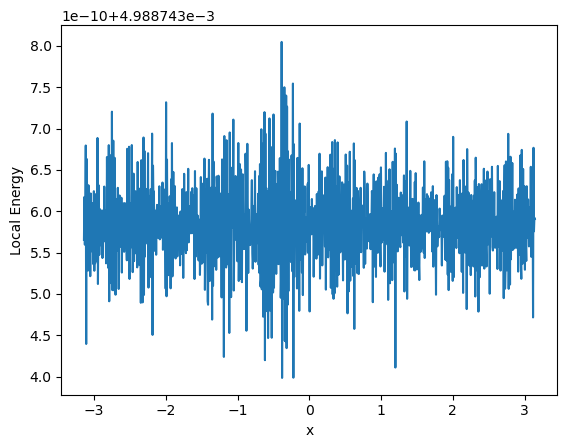

In [32]:
H = hamiltonian_matrix(N_POINTS, GRID_SPACING, PBC)
eigenvalues, eigenstates = torch.linalg.eigh(H)
print(eigenstates.shape)

for i in range(5):
    print(f'Eigenvalue {i}: {eigenvalues[i].item()}')

# check local energy
local_energy = H@eigenstates[:, 0] / eigenstates[:, 0]
plt.plot(x.cpu().numpy(), local_energy.cpu().numpy(), label='Local Energy')
plt.xlabel('x')
plt.ylabel('Local Energy')

In [33]:
n_periods_range = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

ground_state_energy = []
first_excited_state_energy = []
second_excited_state_energy = []
third_excited_state_energy = []
eigstate_histories = []

for i in range(10,20):
    N_PERIODS_FROM_CENTRE_TO_RIGHT = i # number of periods from the center to the right edge
    # A = 2*N_PERIODS_FROM_CENTRE_TO_RIGHT-1 # number of periods in the box centered at zero
    A = N_PERIODS_FROM_CENTRE_TO_RIGHT
    L_BOX = 2*torch.pi/K1 * A
    GRID_SPACING = L_BOX / N_POINTS
    x = torch.linspace(-L_BOX/2,L_BOX/2, N_POINTS).to(device)
    hamiltonian = hamiltonian_matrix(N_POINTS, GRID_SPACING, PBC)
    eigenvalues, eigenstates = torch.linalg.eigh(hamiltonian)
    ground_state_energy.append(eigenvalues[0].item()) 
    first_excited_state_energy.append(eigenvalues[1].item())
    second_excited_state_energy.append(eigenvalues[2].item())
    third_excited_state_energy.append(eigenvalues[3].item())
    norm = torch.trapz(eigenstates[:, 0]**2, x=x)
    eigenstates[:, 0] /= torch.sqrt(norm)  # Normalize the ground state
    eigstate_histories.append(eigenstates[:, 0].cpu().numpy())
    print(f'Norm of ground state for {i} periods: {norm.item()}')

Norm of ground state for 10 periods: 0.06283112099005803
Norm of ground state for 11 periods: 0.06911413600660155
Norm of ground state for 12 periods: 0.07539712308346344
Norm of ground state for 13 periods: 0.08168007958848368
Norm of ground state for 14 periods: 0.08796300286518038
Norm of ground state for 15 periods: 0.09424589023060952
Norm of ground state for 16 periods: 0.10052873897319806
Norm of ground state for 17 periods: 0.1068115463505438
Norm of ground state for 18 periods: 0.11309430958719113
Norm of ground state for 19 periods: 0.11937702587236194


[0.004988719009037106, 0.0049887137835620075, 0.00498870805528766, 0.00498870182285491, 0.004988695084713529, 0.004988687839233615, 0.0049886800846178515, 0.004988671819000893, 0.004988663040305641, 0.004988653746391074]


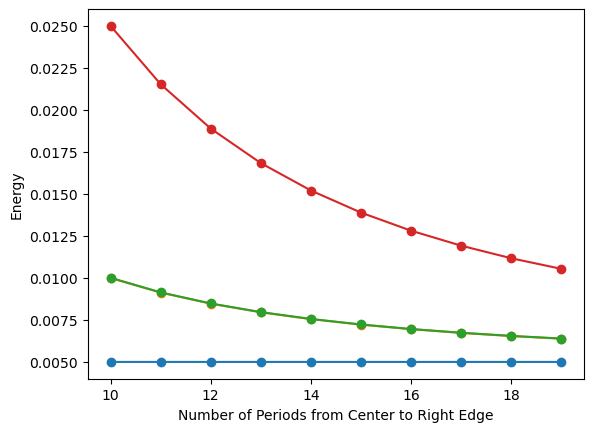

In [34]:
n_periods_range = list(range(10,20))
plt.plot(n_periods_range, ground_state_energy, marker='o', label='Ground State Energy')
plt.plot(n_periods_range, first_excited_state_energy, marker='o', label='First Excited State Energy')
plt.plot(n_periods_range, second_excited_state_energy, marker='o', label='Second Excited State Energy')
plt.plot(n_periods_range, third_excited_state_energy, marker='o', label='Third Excited State Energy')
# plt.xlim(18,21)
# plt.semilogy()
plt.xlabel('Number of Periods from Center to Right Edge')
plt.ylabel('Energy')
print(ground_state_energy)
# plt.xlim(25, 40)
# plt.ylim(0.42,0.45)

In [35]:
print(L_BOX)

119.38052083641213


Text(0, 0.5, 'Eigenstate')

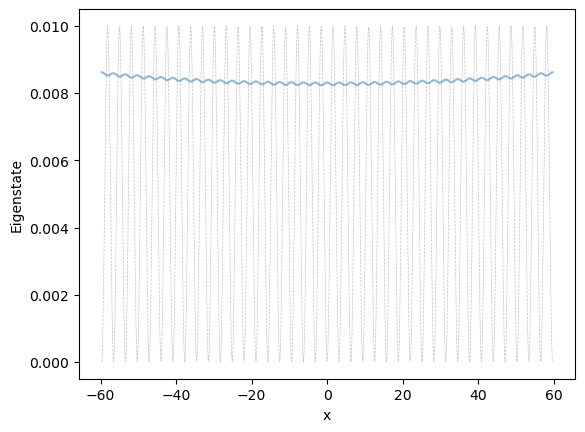

In [38]:
# for eigstate in eigstate_histories[-2:-1]:
plt.plot(x.cpu().numpy(), eigstate_histories[-1]**2, alpha=0.5)
plt.plot(x.cpu().numpy(), V(x,V0).cpu().numpy(), label='Potential V(x)', color='gray', linestyle='dashed', alpha=0.5, linewidth=0.5)
plt.xlabel('x')
plt.ylabel('Eigenstate')

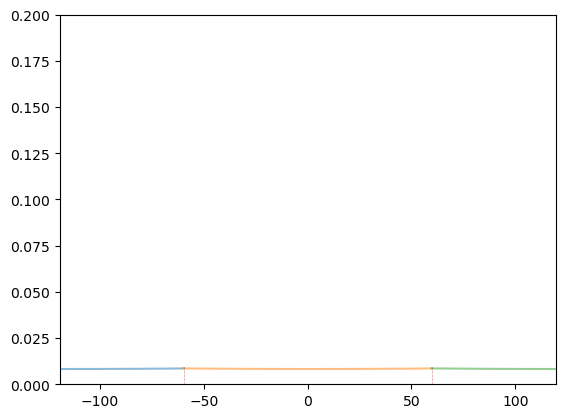

In [39]:
for shift in [-L_BOX, 0, L_BOX]:
    plt.plot(x.cpu().numpy() + shift, eigstate_histories[-1]**2, alpha=0.5)
    # plt.plot(x.cpu().numpy() + shift, V(x).cpu().numpy(), label='Potential V(x)', color='gray', linestyle='dashed', alpha=0.5, linewidth=0.5)
plt.xlim(-L_BOX, L_BOX)
plt.vlines([-L_BOX/2, L_BOX/2], 0, V0, colors='red', linestyles='dashed', alpha=0.5, linewidth=0.5) 
plt.ylim(0, 0.2)
plt.savefig('eigenstate_plot.png', dpi=300)


# Variational approach

In [40]:
import qvarnet
from qvarnet.models.mlp import MLP

In [41]:
# PARAMETERS
HBAR = 1.0
MASS = 1.0
V0 = 1.0
K1 = 1.0
PBC = True

N_POINTS = 1_000
N_PERIODS_FROM_CENTRE_TO_RIGHT = 3 # number of periods from the center to the right edge
# A = 2*N_PERIODS_FROM_CENTRE_TO_RIGHT-1 # number of periods in the box centered at zero
A = N_PERIODS_FROM_CENTRE_TO_RIGHT
L_BOX = 2*torch.pi/K1 * A
GRID_SPACING = L_BOX / N_POINTS
# if GRID_SPACING < torch.pi/(K1):
#     warnings.warn("Aliasing may occur: N_POINTS is too small for the given K1.")

# Create a grid of points
x = torch.linspace(-L_BOX/2,L_BOX/2, N_POINTS).to(device)

# EXACT DIAGONALIZATION

ed_eigvals, ed_eigstates = torch.linalg.eigh(hamiltonian_matrix(N_POINTS, GRID_SPACING, PBC))

In [22]:
import copy

class EarlyStoppingCallback:
    def __init__(self, patience=10, min_delta=1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.best_energy = None
        self.best_model_state = None
        self.epochs_without_improvement = 0
        self.stop_training = False

    def __call__(self, epoch, energy, model):
        # Initialize the best energy if it's the first epoch
        if self.best_energy is None:
            self.best_energy = energy
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.epochs_without_improvement = 0
        else:
            # Check if the energy has improved by more than min_delta
            if energy < (self.best_energy - self.min_delta):
                self.best_energy = energy
                self.best_model_state = copy.deepcopy(model.state_dict())
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

        # If there is no improvement for the specified patience, stop training
        if self.epochs_without_improvement >= self.patience:
            print(f"Stopping training after {epoch+1} epochs due to no improvement in energy.")
            self.stop_training = True

In [23]:
def kinetic_energy(psi, x):
    # First derivative
    dpsi_dx = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi),
                                  create_graph=True, retain_graph=True)[0]
    # Second derivative
    d2psi_dx2 = torch.autograd.grad(dpsi_dx, x, grad_outputs=torch.ones_like(dpsi_dx),
                                    create_graph=True, retain_graph=True)[0]
    return -0.5 * d2psi_dx2

In [56]:
epochs = 10_000

Nh=50

NLayers = 4

layer_dims = [1] + [Nh] * NLayers + [1]

model = MLP(layer_dims=layer_dims, activation="tanh")
model.to(device)

# init weights
for param in model.parameters():
    if len(param.shape) > 1:  # only initialize weights, not biases
        torch.nn.init.xavier_uniform_(param)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

x_train = torch.linspace(-L_BOX/2, L_BOX/2, 1000).view(-1, 1).to(device)
x_train.requires_grad = True

callback = EarlyStoppingCallback(patience=500, min_delta=1e-6)

print_interval = 100

for epoch in (range(epochs)):
    optimizer.zero_grad()
    # Run sampler

    psi = model(x_train) # computes forward pass
    T = kinetic_energy(psi, x_train)
    V_psi = V(x_train) * psi
    H_psi = T + V_psi

    numerator = torch.trapezoid(torch.conj(psi) * H_psi, x_train, dim=0)
    denominator = torch.trapezoid(psi.pow(2), x_train, dim=0)
    energy = numerator / denominator
    energy_copy = energy.clone().detach()
    loss = energy

    # boundary conditions
    norm_psi = torch.trapezoid(psi.pow(2), x_train, dim=0)
    loss += 1e-2 * (norm_psi - 1)**2  # enforce normalization condition
    psi = psi / torch.sqrt(norm_psi + 1e-8)  # normalize wavefunction
    loss += 1e6 * (psi[0] - psi[-1])**2 # penalize boundary conditions
    
    loss.squeeze().backward()
    optimizer.step()

    if epoch % print_interval == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Energy: {energy_copy.item():.4f}")

    # if callback is not None:
    #     callback(epoch, loss, model)

    #     # If the callback indicates stopping, break the training loop
    #     if hasattr(callback, 'stop_training') and callback.stop_training:
    #         model.load_state_dict(callback.best_model_state)
    #         print(f"Training stopped early at epoch {epoch+1}")
    #         break
    
# print(energy)
# model.load_state_dict(callback.best_model_state)

Epoch 1/10000, Loss: 240429.0645, Energy: 0.5164
Epoch 101/10000, Loss: 54.1003, Energy: 0.4996
Epoch 201/10000, Loss: 9.3911, Energy: 0.4994
Epoch 301/10000, Loss: 3.5880, Energy: 0.4993
Epoch 401/10000, Loss: 1.8992, Energy: 0.4993
Epoch 501/10000, Loss: 26.9718, Energy: 0.5000
Epoch 601/10000, Loss: 5.3964, Energy: 0.5000
Epoch 701/10000, Loss: 2.4129, Energy: 0.4999
Epoch 801/10000, Loss: 1.4547, Energy: 0.4999
Epoch 901/10000, Loss: 1.0421, Energy: 0.4999
Epoch 1001/10000, Loss: 0.8335, Energy: 0.4999
Epoch 1101/10000, Loss: 0.7168, Energy: 0.4999
Epoch 1201/10000, Loss: 0.6466, Energy: 0.4999
Epoch 1301/10000, Loss: 0.6022, Energy: 0.4998
Epoch 1401/10000, Loss: 0.5728, Energy: 0.4998
Epoch 1501/10000, Loss: 0.5528, Energy: 0.4998
Epoch 1601/10000, Loss: 0.5389, Energy: 0.4998
Epoch 1701/10000, Loss: 3.2155, Energy: 0.5000
Epoch 1801/10000, Loss: 1.1357, Energy: 0.5000
Epoch 1901/10000, Loss: 0.7640, Energy: 0.5000
Epoch 2001/10000, Loss: 0.6359, Energy: 0.5000
Epoch 2101/10000, 

Norm of wavefunction: 0.9999999900791803
shape of ed_eigstates: torch.Size([1000, 1000])
Norm of eigenstate: 0.01883713362963133
New norm of eigenstate: 0.9999994691339515
......................
Energy from ED: 0.4385287093675823
Energy from VMC: 0.49995979649806144


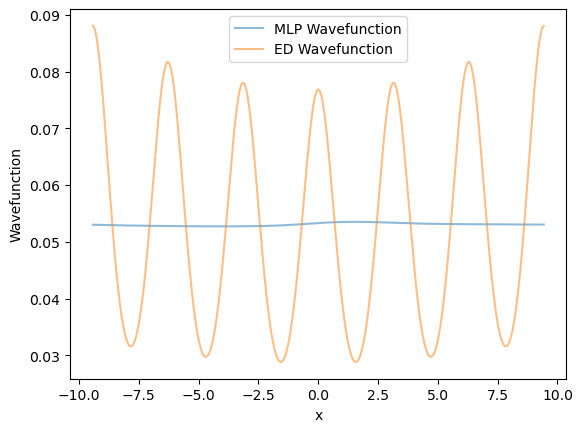

In [58]:
plt.plot(x_train.cpu().detach().numpy(), psi.detach().cpu().numpy()**2, label='MLP Wavefunction', alpha=0.5)
norm = torch.trapezoid(psi.pow(2), x_train, dim=0)
print(f'Norm of wavefunction: {norm.item()}')
norm_other = torch.trapezoid(eigenstates[:, 0].pow(2), x, dim=0)
print(f"shape of ed_eigstates: {ed_eigstates.shape}")
norm_other = torch.trapezoid(ed_eigstates[:,0]**2, x, dim=0)
print(f'Norm of eigenstate: {norm_other.item()}')
psi_ed = ed_eigstates[:, 0].clone().detach()/ torch.sqrt(norm_other + 1e-8)  # normalize eigenstate
new_norm = torch.trapezoid(psi_ed.pow(2), x, dim=0)
print(f'New norm of eigenstate: {new_norm.item()}')
plt.plot(x.cpu().numpy(), psi_ed.cpu().numpy()**2, label='ED Wavefunction', alpha=0.5)

print("......................")
print(f'Energy from ED: {ed_eigvals[0].item()}')
print(f'Energy from VMC: {energy_copy.item()}')
plt.xlabel('x')
plt.ylabel('Wavefunction')
plt.legend();

Text(0, 0.5, 'Wavefunction')

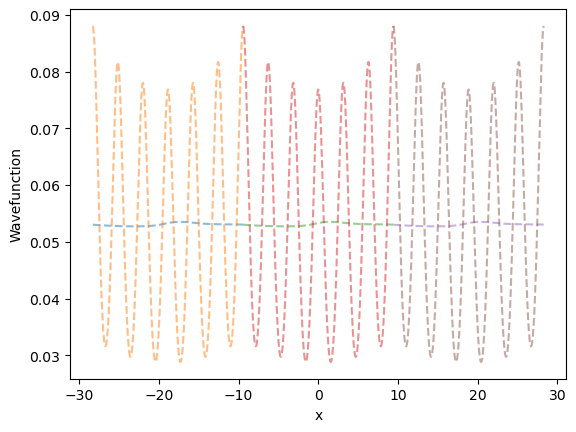

In [59]:
for shift in [-L_BOX, 0, L_BOX]:
    plt.plot(x_train.cpu().detach().numpy() + shift, psi.detach().cpu().numpy()**2, '--', alpha=0.5, label='MLP Wavefunction')
    plt.plot(x.cpu().numpy() + shift, psi_ed.cpu().numpy()**2, '--', alpha=0.5, label='ED Wavefunction')

plt.xlabel('x')

plt.ylabel('Wavefunction')

# Other computation

In [42]:
# PARAMETERS
HBAR = 1.0
MASS = 1.0
V0 = 0.01
K1 = 1.0
PBC = True

N_POINTS = 1_000
N_PERIODS_FROM_CENTRE_TO_RIGHT = 1 # number of periods from the center to the right edge
# A = 2*N_PERIODS_FROM_CENTRE_TO_RIGHT-1 # number of periods in the box centered at zero
A = N_PERIODS_FROM_CENTRE_TO_RIGHT
L_BOX = 2*torch.pi/K1 * A
GRID_SPACING = L_BOX / N_POINTS
# if GRID_SPACING < torch.pi/(K1):
#     warnings.warn("Aliasing may occur: N_POINTS is too small for the given K1.")

# Create a grid of points
x = torch.linspace(-L_BOX/2,L_BOX/2, N_POINTS).to(device)

# EXACT DIAGONALIZATION

ed_eigvals, ed_eigstates = torch.linalg.eigh(hamiltonian_matrix(N_POINTS, GRID_SPACING, PBC))

In [55]:
epochs = 10_000

Nh=50

NLayers = 4

layer_dims = [1] + [Nh] * NLayers + [1]

model = MLP(layer_dims=layer_dims, activation="tanh")
model.to(device)

# init weights
for param in model.parameters():
    if len(param.shape) > 1:  # only initialize weights, not biases
        torch.nn.init.xavier_uniform_(param)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

x_train = torch.linspace(-L_BOX/2, L_BOX/2, 1000).view(-1, 1).to(device)
x_train.requires_grad = True

callback = EarlyStoppingCallback(patience=500, min_delta=1e-6)

wf_hist = []
energy_hist = []

print_interval = 100
print(V0)

for epoch in (range(epochs)):
    optimizer.zero_grad()
    # Run sampler

    psi = model(x_train) # computes forward pass
    T = kinetic_energy(psi, x_train)
    V_psi = V(x_train,V0) * psi
    H_psi = T + V_psi

    numerator = torch.trapezoid(torch.conj(psi) * H_psi, x_train, dim=0)
    denominator = torch.trapezoid(psi.pow(2), x_train, dim=0)
    energy = numerator / denominator
    energy_copy = energy.clone().detach()
    loss = energy

    # boundary conditions
    norm_psi = torch.trapezoid(psi.pow(2), x_train, dim=0)
    loss += 1e-2 * (norm_psi - 1)**2  # enforce normalization condition
    psi = psi / torch.sqrt(norm_psi + 1e-8)  # normalize wavefunction
    loss += 1e6 * (psi[0] - psi[-1])**2 # penalize boundary conditions
    
    loss.squeeze().backward()
    optimizer.step()

    if epoch % print_interval == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Energy: {energy_copy.item():.4f}, V0: {torch.max(V(x_train,V0)).item():.4f}")
        wf_hist.append(psi)
        energy_hist.append(energy_copy.item())

    # if callback is not None:
    #     callback(epoch, loss, model)

    #     # If the callback indicates stopping, break the training loop
    #     if hasattr(callback, 'stop_training') and callback.stop_training:
    #         model.load_state_dict(callback.best_model_state)
    #         print(f"Training stopped early at epoch {epoch+1}")
    #         break
    
# print(energy)
# model.load_state_dict(callback.best_model_state)
print(energy)

0.01
Epoch 1/10000, Loss: 98658.6646, Energy: 0.0196, V0: 0.0100
Epoch 101/10000, Loss: 278.1239, Energy: 0.0050, V0: 0.0100
Epoch 201/10000, Loss: 114.9125, Energy: 0.0049, V0: 0.0100
Epoch 301/10000, Loss: 49.8662, Energy: 0.0047, V0: 0.0100
Epoch 401/10000, Loss: 25.5174, Energy: 0.0046, V0: 0.0100
Epoch 501/10000, Loss: 15.0036, Energy: 0.0045, V0: 0.0100
Epoch 601/10000, Loss: 9.5725, Energy: 0.0044, V0: 0.0100
Epoch 701/10000, Loss: 6.4360, Energy: 0.0043, V0: 0.0100
Epoch 801/10000, Loss: 4.4892, Energy: 0.0042, V0: 0.0100
Epoch 901/10000, Loss: 3.2184, Energy: 0.0040, V0: 0.0100
Epoch 1001/10000, Loss: 2.3570, Energy: 0.0039, V0: 0.0100
Epoch 1101/10000, Loss: 1.7559, Energy: 0.0038, V0: 0.0100
Epoch 1201/10000, Loss: 1.3266, Energy: 0.0036, V0: 0.0100
Epoch 1301/10000, Loss: 1.0140, Energy: 0.0034, V0: 0.0100
Epoch 1401/10000, Loss: 0.7827, Energy: 0.0033, V0: 0.0100
Epoch 1501/10000, Loss: 0.6093, Energy: 0.0031, V0: 0.0100
Epoch 1601/10000, Loss: 0.4778, Energy: 0.0029, V0: 

Norm of wavefunction: 0.9999999899274898
shape of ed_eigstates: torch.Size([1000, 1000])
Norm of eigenstate: 0.006283153509031321
New norm of eigenstate: 0.9999984084450475
......................
Energy from ED: 0.004988743584322679
Energy from VMC: 0.0038738084932973846


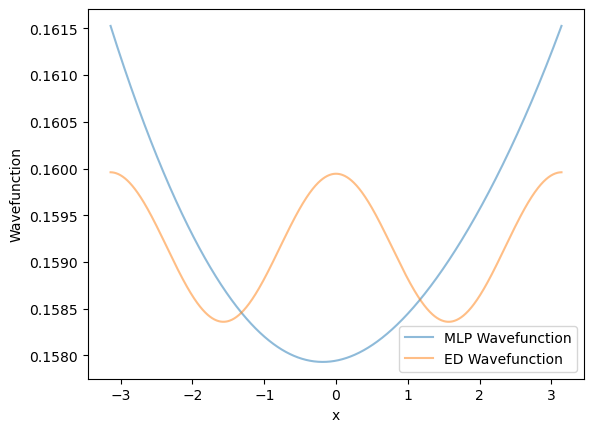

In [58]:
plt.plot(x_train.cpu().detach().numpy(), psi.detach().cpu().numpy()**2, label='MLP Wavefunction', alpha=0.5)
norm = torch.trapezoid(psi.pow(2), x_train, dim=0)
print(f'Norm of wavefunction: {norm.item()}')
print(f"shape of ed_eigstates: {ed_eigstates.shape}")
norm_other = torch.trapezoid(ed_eigstates[:,0]**2, x, dim=0)
print(f'Norm of eigenstate: {norm_other.item()}')
psi_ed = ed_eigstates[:, 0].clone().detach()/ torch.sqrt(norm_other + 1e-8)  # normalize eigenstate
new_norm = torch.trapezoid(psi_ed.pow(2), x, dim=0)
print(f'New norm of eigenstate: {new_norm.item()}')
plt.plot(x.cpu().numpy(), psi_ed.cpu().numpy()**2, label='ED Wavefunction', alpha=0.5)

print("......................")
print(f'Energy from ED: {ed_eigvals[0].item()}')
print(f'Energy from VMC: {energy_copy.item()}')
plt.xlabel('x')
plt.ylabel('Wavefunction')
plt.legend();

In [62]:
for i,energy in enumerate(energy_hist):
    if energy < energy_copy.item():
        psi = wf_hist[i]  # Ensure psi requires gradients for kinetic energy calculation
        T = kinetic_energy(psi, x_train)
        V_psi = V(x_train,V0) * psi
        H_psi = T + V_psi
        numerator = torch.trapezoid(torch.conj(psi) * H_psi, x_train, dim=0)
        denominator = torch.trapezoid(psi.pow(2), x_train, dim=0)
        energy = numerator / denominator
        plt.plot(x_train.cpu().detach().numpy(), wf_hist[i].pow(2).cpu().detach().numpy(), label=f'Wavefunction at epoch {i*print_interval}', alpha=0.5)
        plt.show()
        

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

#### Test ft

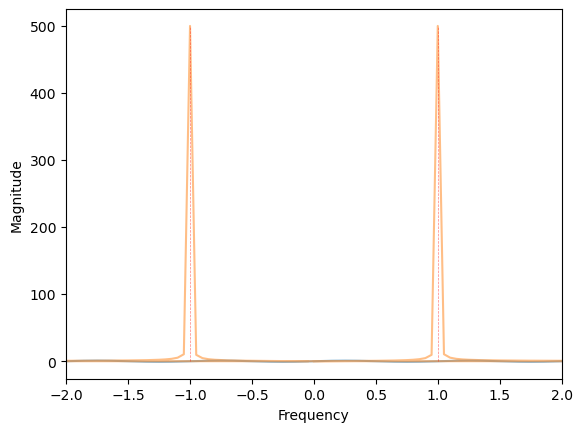

In [85]:
x_test = torch.linspace(-10, 10, 1000).view(-1, 1).to(device)

y_test = torch.sin(2*torch.pi*x_test)
plt.plot(x_test.cpu().numpy(), y_test.cpu().numpy(), label='Test Function', alpha=0.5)

ft_y = torch.fft.fft(y_test.squeeze())
freqs = torch.fft.fftfreq(len(y_test), d=(x_test[1] - x_test[0]).item())
plt.plot(freqs.cpu().numpy(), ft_y.abs().cpu().numpy(), label='FFT of Test Function', alpha=0.5)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim(-2, 2)
plt.vlines([-1,1], 0, ft_y.abs().max().item(), colors='red', linestyles='dashed', alpha=0.5, linewidth=0.5, label='Expected Frequency (1 Hz)')

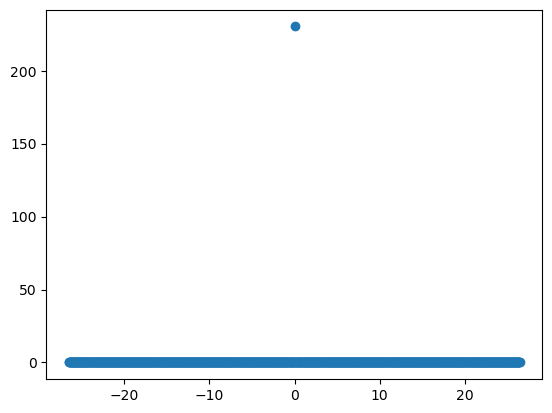

In [87]:
# plot ft of ed_eigstates[:, 0]

psi_ed_ft = torch.fft.fft(psi_ed)

plt.scatter(torch.fft.fftfreq(N_POINTS, d=GRID_SPACING).cpu().numpy(), psi_ed_ft.abs().cpu().numpy(), label='FT of ED Wavefunction', alpha=1)
# plt.xlim(-0.5, 0.5)
# plt.semilogy()

# analytic vs ED

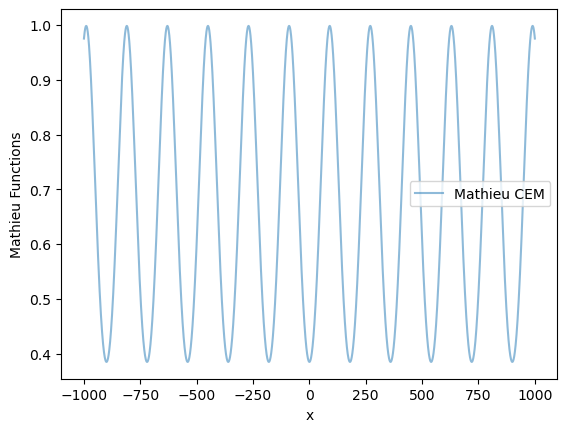

In [10]:
from scipy.special import mathieu_cem, mathieu_sem
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-1000, 1000, 10000)
mathieu_c = mathieu_cem(0, 1, x)
mathieu_s = mathieu_sem(0, 1, x)
plt.plot(x, mathieu_c[0][:], label='Mathieu CEM', alpha=0.5)
# plt.plot(x, mathieu_s[0][:], label='Mathieu SEM', alpha=0.5)
plt.xlabel('x')
plt.ylabel('Mathieu Functions')
plt.legend()